# Data Selection for General Medicine 

Iain Bertram 

17 April 2024 -  

Translated to use SnowFlake only 

Generalised for any hospital 

This data selection is based on the table PRD_DAP_EMR_DB.DBO.CV3CLIENT and test results and observations taken from:

### Results 

- PRD_DAP_EMR_DB.DBO.CV3BASICOBSERVATION 
- PRD_DAP_EMR_DB.DBO.CV3ORDER

### Observations 

- PRD_DAP_EMR_DB.DBO.CV3CLIENTDOCUMENT
- PRD_DAP_EMR_DB.DBO.CV3CLIENTVISIT 
- PRD_DAP_EMR_DB.DBO.CV3OBSERVATIONENTRYITEM 
- PRD_DAP_EMR_DB.DBO.CV3OBSERVATIONDOCUMENT
- PRD_DAP_EMR_DB.DBO.CV3OBSERVATION 
- PRD_DAP_EMR_DB.DBO.SCMOBSFSLISTVALUES

### Diagnoses 

- PRD_DAP_EMR_DB.DBO.SXARCMAbstractVisitDetail
- PRD_DAP_EMR_DB.DBO.SXARCMAbstractDiagnosisDetail

### ED Visit Reason 

- PRD_DAP_EMR_DB.DBO.CV3CLIENTDOCUMENT
- PRD_DAP_EMR_DB.DBO.CV3OBSERVATIONDOCUMENT
- PRD_DAP_EMR_DB.DBO.SCMOBSFSLISTVALUES
- PRD_DAP_EMR_DB.DBO.CV3OBSCATALOGMASTERITEM

### Rough Dates 


2023 Calender Year 


In [3]:
# Import Python Libraries 

import sys
import os
import pickle
import time 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from pandasql import sqldf
import sqlalchemy
import snowflake.connector

import pyodbc

from tqdm import tqdm

import Utilities
import importlib
importlib.reload(Utilities)

import re
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)



# show all dataframe columns 

pd.set_option('display.max_columns', None)

c:\Users\ibertr02\venvs\ceihml\Lib\site-packages\snowflake\connector\options.py:103: UserWarning: You have an incompatible version of 'pyarrow' installed (15.0.2), please install a version that adheres to: 'pyarrow<10.1.0,>=10.0.1; extra == "pandas"'
  warn_incompatible_dep(
Failed to import ArrowResult. No Apache Arrow result set format can be used. ImportError: DLL load failed while importing arrow_iterator: The specified procedure could not be found.


## Date Ranges for data 

Removed Facility selection and looking at Journeys that include hospital transfers. 

Added validation range: ('2023-04-01', '2023-10-01')

Update validation through end of July (doubling) 

In [5]:

# Facility = 'LMH'


# dates = {
#     'RAH':('2023-10-01', '2024-01-01'),
#     'QEH':('2023-10-01', '2024-01-01'),
#     'LMH':('2023-10-01', '2024-01-01'),
#     'MPH':('2023-10-01', '2024-01-01'),
#     'FMC':('2023-10-01', '2024-01-01'),
#     'NHS':('2023-10-01', '2024-01-01'),
# }

start_date =  '2023-09-28'  #dates[Facility][0]
end_date   =  '2024-01-01' #dates[Facility][1]

select_start_date = '2023-10-01'

DataReasons = "Verification"

# Validation 

start_date =  '2023-03-28'  #dates[Facility][0]
end_date   =  '2023-10-01' #dates[Facility][1]

select_start_date = '2023-04-01'

DataReasons = "Verification"

# Main Data Set 

dates = {
    'RAH':('2020-07-01','2024-01-01'),
    'QEH':('2017-01-01', '2024-01-01'),
    'LMH':('2023-01-01', '2024-01-01'),
    'MPH':('2023-01-01', '2024-01-01'),
    'FMC':('2021-08-01', '2024-01-01'),
    'NHS':('2017-01-01', '2024-01-01'),
}

start_date =  '2023-01-01'  #dates[Facility][0]
end_date   =  '2024-01-01' #dates[Facility][1]

select_start_date = '2023-01-01'

DataReasons = "Training"


start_date =  '2024-01-01'  #dates[Facility][0]
end_date   =  '2024-08-01' #dates[Facility][1]

select_start_date = '2024-01-01'

DataReasons = "Verification"
# clinics=Utilities.clinics(Facility)
    
# print(Facility,start_date,end_date,clinics)

## Connection to SnowFlake 

        con = snowflake.connector.connect(
        account='wt61814.australia-east.privatelink',
        user="iain.bertram@sa.gov.au",
        database="DEV_DAP_CAE05_DB",
        warehouse="DEV_DAP_CAE05_M_WH",
        authenticator="externalbrowser",


In [3]:
# 'snowflake://<user_login_name>:<password>@<account_identifier>/<database_name>/<schema_name>?warehouse=<warehouse_name>&role=<role_name>'

In [6]:
con = Utilities.getConnection()
con.warehouse

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/bda528f7-fca9-432f-bc98-bd7e90d40906/saml2?SAMLRequest=pZNRb9sgFIX%2FisWebWPspDGKU6XNumRqNitxq6lvxOCUBYMHOG7%2B%2FbCTSN1D%2B7I3BOfynXsPTG%2FfauEdmTZcyQxEAQQek6WiXO4z8FQ8%2BBPgGUskJUJJloETM%2BB2NjWkFg2et%2FZVbtiflhnruYukwf1BBlotsSKGGyxJzQy2Jd7O148YBRATY5i2DgcuJdRwx3q1tsFh2HVd0MWB0vsQQQhDmIZO1Uu%2BgHeI5nNGo5VVpRLXkjfX0weIKIRJj3AKR8gvhXdcnkfwGWV3Fhm8LIrcz39uC%2BDNr93dK2namukt00desqfN49mA6R3YcTSJkoC0xmoiOPEZMTZoND8SywSXh8BI1VWCHFip6qa1DhO4VVgxGgq15254q0UGmgOnzV0t8phsvlGy2a53eqleEBLFeDF6%2Fr78fYzi5tfktPl6gId1Cbzna9Soj3plTMtWsg%2FYui2IEj%2BCfpQUCOF4hEdxgNLRC%2FAWLmAuiR0qr10MPoKal1oZVVklnXE2uNxRMkKT6savSpL6SYwqf1emE39Hb1gKaQJTOA77GBE4PyU8GNGz%2Fx7QNHx%2F3eWZ%2FnDJrRa5Erw8eQ9K18R%2BHGwURMMOp341SDGrCRdzSjUzxgUshOruNX

'DEV_DAP_CAE05_M_WH'

## Get Hospital Visits (Episodes of Care)

Removed ED visit reason as multiple entries can exist per visit (treat like diagnoses)

In [7]:
importlib.reload(Utilities)
visits_df = Utilities.getVisits(start_date,end_date, con)

In [8]:
visits_df.head()

,CLIENTGUID,CHARTGUID,VISITGUID,JOURNEY_ID,IRSD_SCORE,IRSD_DECILE,AGEONADMISSION,GENDERCODE,IndiginousStatus,LEVELCODE,HOSIPTALPROXY,CHARTRANK,VISITRANK,ACTIVE,VISITSTATUS,INTERNALVISITSTATUS,TYPECODE,CARELEVELCODE,PRIMARYDIAGNOSISCODE,diagnosis_code_desc,PRIMARYPROCEDURECODE,DRG,DRGDescription,MDC,TRIAGE_CATEGORY,EDDIAGNOSISCODE,EDDIAGNOSISCODEDESCRIPTION,CURRENTLOCATION,ADMITDTM,DISCHARGEDTM,LOSNIGHTS,LOSHOUR,DISCHARGEDISPOSITION,DISCHARGELOCATION,CURRENTSERVICE,OLDSERVICE,CURRENTSERVICEDTM,GROUPCODE,SERVICEDESCRIPTION,ADMITSOURCE,ADMITTYPE,EPISODEOFCARE,SOURCEOFREFERRAL,Transfer Service,SAH_DIAGNOSIS,SAH_VISIT_TYPE,SAH_ADMIT_SERVICE,WL Patient Category - Intent,WL Election,CUD_EPISODE_OFCARE,CUD_PATIENT_CATEGORY,CUD_ADMISSION_CATEGORY,CUD_ADMISSION_ELECTION
0,1000200,2025045200170,2917510300270,1000009 - 1,990,5,57,Male,Not Aboriginal-TSI,FMC,FMC,1,1,False,DSC,DSC,Emergency,Emergency,None,None,None,None,None,None,4,T141,Open wound of unspecified body region,FMC-ED-Waiting Room Ambulatory,2024-06-04 02:43:00+00:00,2024-06-04 03:28:00+00:00,0,0,ED11 Alternate Treatment,None,FMC Emergency,,2024-06-04 02:43:30.087000+00:00,FMC-EMER,FMC Emergency,ED GP,Emergency,None,ED GP,None,Open wound of unspecified body region :Dx,Emergency,None,None,None,None,None,None,None
1,1000200,2025798900170,2918819200270,1000009 - 2,990,5,57,Male,Not Aboriginal-TSI,FMC,FMC,2,1,False,DSC,DSC,Emergency,Emergency,None,None,None,None,None,None,3,S9181,Open wound (of any part of ankle and foot) com...,FMC-ED-West Chairs,2024-06-04 21:42:00+00:00,2024-06-05 01:12:00+00:00,0,3,ED02 Admit as Inpatient,None,FMC Emergency,,2024-06-04 21:42:21.973000+00:00,FMC-EMER,FMC Emergency,ED Self-Family-Friends,Emergency,None,ED Self-Family-Friends,None,Open wound (of any part of ankle and foot) com...,Emergency,FMC IP Orthopaedics / ORTHO,None,None,None,None,None,None
2,1000200,2025798900170,2919361400270,1000009 - 2,990,5,57,Male,Not Aboriginal-TSI,FMC,FMC,2,2,False,DSC,DSC,Inpatient,Surgical,S925,Fracture of other toe,9066501,None,None,None,None,None,None,FMC-5C-13_16-16,2024-06-04 23:10:00+00:00,2024-06-05 09:42:00+00:00,0,11,IP Home,None,FMC IP Orthopaedics / ORTHO,,2024-06-05 01:19:17+00:00,FMC-ORTSUR,FMC IP Orthopaedics / ORTHO,IP Casualty-Emergency,Emergency,Acute,IP Casualty-Emergency,None,Open wound (of any part of ankle and foot) com...,Inpatient,None,Overnight Stay,Public,Acute,Overnight Stay,Ordinary,Public
3,1000200,1960289000170,2803357600270,1000009 - 3,990,5,57,Male,Not Aboriginal-TSI,FMC,FMC,4,1,False,DSC,DSC,Inpatient,Medical,D046,Ca in situ skin upper limb incl shoulder,3007100,None,None,None,None,None,None,FMC-L2MC-01,2024-06-28 00:53:00+00:00,2024-06-28 02:50:00+00:00,0,2,IP Home,None,FMC IP Dermatology / DERM,,2024-03-21 05:24:35.813000+00:00,FMC-DERM,FMC IP Dermatology / DERM,IP Outpatient department,Not Applicable,Acute,IP Outpatient department,None,None,Inpatient,None,Day Only,Public,Acute,Day Only,Ordinary,Public
4,1200200,1906118400170,2709661100270,1000011 - 3,1069,9,75,Female,Not Aboriginal-TSI,FMC,FMC,1,1,False,DSC,DSC,Emergency,Emergency,None,None,None,None,None,None,2,F051,Delirium superimposed on dementia,FMC-ED-South 16,2024-01-19 04:29:00+00:00,2024-01-19 13:52:00+00:00,1,10,ED02 Admit as Inpatient,None,FMC Emergency,,2024-01-19 04:29:37.060000+00:00,FMC-EMER,FMC Emergency,ED First Aid Provider,Emergency,None,ED First Aid Provider,None,Delirium superimposed on dementia :Dx,Emergency,FMC IP General Medical / AMU1,None,None,None,None,None,None


### Save to DataFiles 

In [9]:
Data_Storage_File = 'DataFiles\Visits_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump(visits_df, file)

DataFiles\Visits_2024-01-01_2024-08-01_Verification_Stage_01.pkl


In [7]:
Data_Storage_File = 'DataFiles\Visits_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'rb') as file:
    visits_df = pd.read_pickle(file)

DataFiles\Visits_2024-01-01_2024-08-01_Verification_Stage_01.pkl


In [8]:
print(len(visits_df.index))


432383


### Get List of Diagnoses 

This will be two lists, those the Episode of Care started with and hospital acquired. 



In [11]:
# Commentd out so only select data from database when required 
importlib.reload(Utilities)
diagnoses_df,diagnoses_HA_df = Utilities.getDiagnosis( start_date,end_date, con)

In [12]:
# Commentd out so only select data from database when required 
# 'DataFiles\Visits_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
Data_Storage_File = 'DataFiles\Visits_Diagnoses_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump((diagnoses_df,diagnoses_HA_df), file)

DataFiles\Visits_Diagnoses_2024-01-01_2024-08-01_Verification_Stage_01.pkl


In [9]:
Data_Storage_File = 'DataFiles\Visits_Diagnoses_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'rb') as file:
    (diagnoses_df,diagnoses_HA_df) = pd.read_pickle(file)

DataFiles\Visits_Diagnoses_2024-01-01_2024-08-01_Verification_Stage_01.pkl


### Get List of ED Visit Reasons 

In [13]:
# Commentd out so only select data from database when required 
importlib.reload(Utilities)
visitReasons_df = Utilities.getEDVisitReasons( start_date,end_date, con)

In [14]:
# Commentd out so only select data from database when required 
Data_Storage_File = 'DataFiles\Visits_EDVisitReasons_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump(visitReasons_df, file)

DataFiles\Visits_EDVisitReasons_2024-01-01_2024-08-01_Verification_Stage_01.pkl


In [10]:
Data_Storage_File = 'DataFiles\Visits_EDVisitReasons_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'rb') as file:
    visitReasons_df = pd.read_pickle(file)

DataFiles\Visits_EDVisitReasons_2024-01-01_2024-08-01_Verification_Stage_01.pkl


### Join Diagnoses to Visits 

In [11]:
temp_df = pd.merge(visits_df,diagnoses_df, left_on="VISITGUID", right_on="VisitGUID" , how='left' )
temp_df.drop('VisitGUID', axis=1, inplace=True)
temp_df.rename(columns={"ALLDIAGNOSIS":"DIAGNOSIS_LIST"},inplace=True)


temp2_df = pd.merge(temp_df,diagnoses_HA_df, 
    left_on="VISITGUID", right_on="VisitGUID" , how='left' )
temp2_df.drop('VisitGUID', axis=1, inplace=True)
temp2_df.rename(columns={"ALLDIAGNOSIS":"HA_DIAGNOSIS_LIST"},inplace=True)

temp2_df = pd.merge(temp2_df,visitReasons_df, 
    left_on="VISITGUID", right_on="VISITGUID" , how='left' )
# temp2_df.drop('VisitGUID', axis=1, inplace=True)
# temp2_df.rename(columns={"ALLDIAGNOSIS":"HA_DIAGNOSIS_LIST"},inplace=True)


# temp2_df.head()


In [12]:
visitReasons_df.head()

,VISITGUID,ED_VISIT_REASON
0,2683302900270,Cardiovascular.Chest Pain
1,2683375700270,Neuro.Weakness/Paraesthesia
2,2683387800270,Gastrointestinal.Abdominal Pain
3,2683427000270,Cardiovascular.Chest Pain
4,2683460800270,Neuro.Headache


### Add Diagnosis Flags 

In [13]:
importlib.reload(Utilities)
temp3_df = Utilities.addFlags(temp2_df)
# print(temp2_df.iloc[0].DIAGNOSIS_LIST)
# Utilities.sepsis_flag(temp2_df.iloc[0].DIAGNOSIS_LIST)

In [14]:
temp3_df['DIAGNOSIS_LIST'] = temp3_df['DIAGNOSIS_LIST'].fillna('')
temp3_df['HA_DIAGNOSIS_LIST'] = temp3_df['HA_DIAGNOSIS_LIST'].fillna('')

In [15]:
temp3_df.head()

,CLIENTGUID,CHARTGUID,VISITGUID,JOURNEY_ID,IRSD_SCORE,IRSD_DECILE,AGEONADMISSION,GENDERCODE,IndiginousStatus,LEVELCODE,HOSIPTALPROXY,CHARTRANK,VISITRANK,ACTIVE,VISITSTATUS,INTERNALVISITSTATUS,TYPECODE,CARELEVELCODE,PRIMARYDIAGNOSISCODE,diagnosis_code_desc,PRIMARYPROCEDURECODE,DRG,DRGDescription,MDC,TRIAGE_CATEGORY,EDDIAGNOSISCODE,EDDIAGNOSISCODEDESCRIPTION,CURRENTLOCATION,ADMITDTM,DISCHARGEDTM,LOSNIGHTS,LOSHOUR,DISCHARGEDISPOSITION,DISCHARGELOCATION,CURRENTSERVICE,OLDSERVICE,CURRENTSERVICEDTM,GROUPCODE,SERVICEDESCRIPTION,ADMITSOURCE,ADMITTYPE,EPISODEOFCARE,SOURCEOFREFERRAL,Transfer Service,SAH_DIAGNOSIS,SAH_VISIT_TYPE,SAH_ADMIT_SERVICE,WL Patient Category - Intent,WL Election,CUD_EPISODE_OFCARE,CUD_PATIENT_CATEGORY,CUD_ADMISSION_CATEGORY,CUD_ADMISSION_ELECTION,DIAGNOSIS_LIST,HA_DIAGNOSIS_LIST,ED_VISIT_REASON,SepsisFlag,COPDFlag,PneumoniaFlag,PEFlag,HeartFailureFlag,UTIFlag,HASepsisFlag
0,1000200,2025045200170,2917510300270,1000009 - 1,990,5,57,Male,Not Aboriginal-TSI,FMC,FMC,1,1,False,DSC,DSC,Emergency,Emergency,None,None,None,None,None,None,4,T141,Open wound of unspecified body region,FMC-ED-Waiting Room Ambulatory,2024-06-04 02:43:00+00:00,2024-06-04 03:28:00+00:00,0,0,ED11 Alternate Treatment,None,FMC Emergency,,2024-06-04 02:43:30.087000+00:00,FMC-EMER,FMC Emergency,ED GP,Emergency,None,ED GP,None,Open wound of unspecified body region :Dx,Emergency,None,None,None,None,None,None,None,,,Laceration.Other,0,0,0,0,<NA>,0,0
1,1000200,2025798900170,2918819200270,1000009 - 2,990,5,57,Male,Not Aboriginal-TSI,FMC,FMC,2,1,False,DSC,DSC,Emergency,Emergency,None,None,None,None,None,None,3,S9181,Open wound (of any part of ankle and foot) com...,FMC-ED-West Chairs,2024-06-04 21:42:00+00:00,2024-06-05 01:12:00+00:00,0,3,ED02 Admit as Inpatient,None,FMC Emergency,,2024-06-04 21:42:21.973000+00:00,FMC-EMER,FMC Emergency,ED Self-Family-Friends,Emergency,None,ED Self-Family-Friends,None,Open wound (of any part of ankle and foot) com...,Emergency,FMC IP Orthopaedics / ORTHO,None,None,None,None,None,None,,,Laceration.Lower Limb,0,0,0,0,<NA>,0,0
2,1000200,2025798900170,2919361400270,1000009 - 2,990,5,57,Male,Not Aboriginal-TSI,FMC,FMC,2,2,False,DSC,DSC,Inpatient,Surgical,S925,Fracture of other toe,9066501,None,None,None,None,None,None,FMC-5C-13_16-16,2024-06-04 23:10:00+00:00,2024-06-05 09:42:00+00:00,0,11,IP Home,None,FMC IP Orthopaedics / ORTHO,,2024-06-05 01:19:17+00:00,FMC-ORTSUR,FMC IP Orthopaedics / ORTHO,IP Casualty-Emergency,Emergency,Acute,IP Casualty-Emergency,None,Open wound (of any part of ankle and foot) com...,Inpatient,None,Overnight Stay,Public,Acute,Overnight Stay,Ordinary,Public,S925 S9181 W291 Y929 U731 E109 Z948 U833 U823,,NaN,0,0,0,0,0,0,0
3,1000200,1960289000170,2803357600270,1000009 - 3,990,5,57,Male,Not Aboriginal-TSI,FMC,FMC,4,1,False,DSC,DSC,Inpatient,Medical,D046,Ca in situ skin upper limb incl shoulder,3007100,None,None,None,None,None,None,FMC-L2MC-01,2024-06-28 00:53:00+00:00,2024-06-28 02:50:00+00:00,0,2,IP Home,None,FMC IP Dermatology / DERM,,2024-03-21 05:24:35.813000+00:00,FMC-DERM,FMC IP Dermatology / DERM,IP Outpatient department,Not Applicable,Acute,IP Outpatient department,None,None,Inpatient,None,Day Only,Public,Acute,Day Only,Ordinary,Public,D046 D043 D367,,NaN,0,0,0,0,0,0,0
4,1200200,1906118400170,2709661100270,1000011 - 3,1069,9,75,Female,Not Aboriginal-TSI,FMC,FMC,1,1,False,DSC,DSC,Emergency,Emergency,None,None,None,None,None,None,2,F051,Delirium superimposed on dementia,FMC-ED-South 16,2024-01-19 04:29:00+00:00,2024-01-19 13:52:00+00:00,1,10,ED02 Admit as Inpatient,None,FMC Emergency,,2024-01-19 04:29:37.060000+00:00,FMC-EMER,FMC Emergency,ED First Aid Provider,Emergency,None,ED First Aid Provider,None,Delirium superimposed on dementia :Dx,Emergency,FMC IP General Medical / AMU1,None,None,None,None,None,None,,,Neuro.Other,0,0,0,0,<NA>,0,0


In [16]:
temp3_df.loc[(temp3_df.PRIMARYDIAGNOSISCODE=='I500')&(temp3_df.TYPECODE=='Inpatient')&(temp3_df.EPISODEOFCARE=='Acute')]

,CLIENTGUID,CHARTGUID,VISITGUID,JOURNEY_ID,IRSD_SCORE,IRSD_DECILE,AGEONADMISSION,GENDERCODE,IndiginousStatus,LEVELCODE,HOSIPTALPROXY,CHARTRANK,VISITRANK,ACTIVE,VISITSTATUS,INTERNALVISITSTATUS,TYPECODE,CARELEVELCODE,PRIMARYDIAGNOSISCODE,diagnosis_code_desc,PRIMARYPROCEDURECODE,DRG,DRGDescription,MDC,TRIAGE_CATEGORY,EDDIAGNOSISCODE,EDDIAGNOSISCODEDESCRIPTION,CURRENTLOCATION,ADMITDTM,DISCHARGEDTM,LOSNIGHTS,LOSHOUR,DISCHARGEDISPOSITION,DISCHARGELOCATION,CURRENTSERVICE,OLDSERVICE,CURRENTSERVICEDTM,GROUPCODE,SERVICEDESCRIPTION,ADMITSOURCE,ADMITTYPE,EPISODEOFCARE,SOURCEOFREFERRAL,Transfer Service,SAH_DIAGNOSIS,SAH_VISIT_TYPE,SAH_ADMIT_SERVICE,WL Patient Category - Intent,WL Election,CUD_EPISODE_OFCARE,CUD_PATIENT_CATEGORY,CUD_ADMISSION_CATEGORY,CUD_ADMISSION_ELECTION,DIAGNOSIS_LIST,HA_DIAGNOSIS_LIST,ED_VISIT_REASON,SepsisFlag,COPDFlag,PneumoniaFlag,PEFlag,HeartFailureFlag,UTIFlag,HASepsisFlag
327,80700200,2074367700170,3005547500270,1000806 - 7,966,3,79,Female,Not Aboriginal-TSI,FMC,FMC,7,2,False,DSC,DSC,Inpatient,Medical,I500,Congestive heart failure,9555003,None,None,None,None,None,None,FMC-Transit Lounge-07-07,2024-07-27 12:02:00+00:00,2024-07-28 05:20:00+00:00,1,17,IP Home,None,FMC IP General Medical / AMU1,,2024-07-28 00:35:02.800000+00:00,FMC-GENMED,FMC IP General Medical / AMU1,IP Casualty-Emergency,Emergency,Acute,IP Casualty-Emergency,None,Decompensated chronic heart failure :Dx,Inpatient,None,Overnight Stay,Public,Acute,Overnight Stay,Ordinary,Public,I500 N390 Z043 W012 Y9205 U739 B956 Z911 E1122...,,NaN,0,0,0,0,1,1,0
977,282100200,1918255500170,2730628500270,1002820 - 4,754,1,63,Male,Not Aboriginal-TSI,LMH,LMH,1,2,False,DSC,DSC,Inpatient,Medical,I500,Congestive heart failure,9220902,None,None,None,None,None,None,LMH-Ward 2D-13-13,2024-02-03 07:48:00+00:00,2024-02-15 05:40:00+00:00,12,286,IP Home,None,LMH IP General Medical / WHITE,LMH IP Acute Medical Unit / AM,2024-02-04 04:00:57.917000+00:00,LMH-LGMED,LMH IP General Medical / WHITE,IP Casualty-Emergency,Emergency,Acute,IP Casualty-Emergency,LMH IP Acute Medical Unit / AMU A,Congestive heart failure :Dx,Inpatient,None,Overnight Stay,Public,Acute,Overnight Stay,Ordinary,Public,I500 J9601 J9611 G4732 E6620 E875 J441 E1129 N...,,NaN,0,1,0,0,1,0,0
1299,426900200,2003870700170,2880217300270,1004268 - 6,906,1,90,Male,Not Aboriginal-TSI,FMC,FMC,4,2,False,DSC,DSC,Inpatient,Medical,I500,Congestive heart failure,None,None,None,None,None,None,None,FMC-2S-18-18,2024-05-12 05:02:00+00:00,2024-05-13 06:16:00+00:00,1,25,IP Res Care Facility-Usual Res,None,FMC IP General Medical / RCOT,,2024-05-12 06:56:05.147000+00:00,FMC-GENMED,FMC IP General Medical / RCOT,IP Casualty-Emergency,Emergency,Acute,IP Casualty-Emergency,None,Dyspnoea :Dx,Inpatient,None,Overnight Stay,Public,Acute,Overnight Stay,Ordinary,Public,I500 R410 N179 N184 Z8643 U823 U821,,NaN,0,0,0,0,1,0,0
1393,467700200,2015069300170,2900302400270,1004676 - 8,906,1,78,Male,Not Aboriginal-TSI,FMC,FMC,8,2,False,DSC,DSC,Inpatient,Medical,I500,Congestive heart failure,9602700,None,None,None,None,None,None,FMC-5D-13_16-16,2024-05-23 11:45:00+00:00,2024-05-27 07:01:00+00:00,4,91,IP Home,None,FMC IP General Medical / GMF6,FMC IP General Medical / AMU1,2024-05-23 15:09:15.223000+00:00,FMC-GENMED,FMC IP General Medical / GMF6,IP Casualty-Emergency,Emergency,Acute,IP Casualty-Emergency,FMC IP General Medical / GMF6,Fluid overload :Dx,Inpatient,None,Overnight Stay,Public,Acute,Overnight Stay,Ordinary,Public,I500 K922 D683 Y442 Y9223 J441 I10 D649,,NaN,0,1,0,0,1,0,0
1601,573900200,1995114200170,2866086300270,1005738 - 3,1055,8,70,Male,Not Aboriginal-TSI,FMC,FMC,1,2,False,DSC,DSC,Inpatient,Medical,I500,Congestive heart failure,9555003,None,None,None,None,None,None,FMC-3GOF-12_15-15,2024-05-02 08:26:00+00:00,2024-05-06 08:15:00+00:00,4,96,IP Home,None,FMC IP General Medical / GM SH,FMC IP General Medical / AMU1,2024-05-02 13:16:43.483000+00:00,FMC-GENMED,FMC IP General Medical / GM SHORT STAY,IP Casualty-Emergency,Emergency,Acute,IP Casualty-Em

In [17]:
temp3_df['SERVICEDESCRIPTION'].unique()

array(['FMC Emergency', 'FMC IP Orthopaedics / ORTHO',
       'FMC IP Dermatology / DERM', 'FMC IP General Medical / RCOT',
       'NHS Emergency', 'FMC IP Gen Surg / GGIS',
       'NHS Orthopaedic / ARTHROPLAST',
       'FMC IP Orthopaedics / ARTHROPLAST', 'NHS General Medical / RENAL',
       'FMC IP Dialysis / DIAL', 'FMC IP Vascular / VASC',
       'FMC IP General Rehab / RHB EAST', 'FMC IP Nephrology / RENAL',
       'FMC IP General Medical / AMU1', 'RAH Emergency',
       'FMC IP Respiratory / RESP', 'FMC IP Ophthalmology / OPHTH',
       'FMC IP Gen Surg / BREAST', 'FMC IP Plastic Surgery / PLAS',
       'FMC IP Gynaecology / GYN', 'FMC IP Urology / UROL',
       'FMC IP Emergency / EMERG', 'LMH Emergency',
       'LMH IP Emergency / EECU', 'RAH MH ED / 292',
       'FMC IP Acute MH / FMH', 'RAH Vascular / 040', 'RAH Urology / 061',
       'MPH Emergency', 'MPH IP Emergency / EECU',
       'RAH General Medical / 106', 'RAH Hospital at Home Medical / 088',
       'FMC IP Gen Surg

### Select All GenMed Acute Visits 

Require at least stays of > 48 hours 

In [18]:
Emergency_df = temp3_df.loc[temp3_df.TYPECODE=='Emergency'].copy()

In [19]:
Emergency_df.GROUPCODE.unique()

array(['FMC-EMER', 'NHS-EMERG', 'RAH-EMERG', 'LMH-LEMER', 'MPH-MEMER',
       'QEH-EMERG', 'FMC-FVEMER', 'LMH-LWAUED', 'LMH-LBCE', 'LMH-LIROED',
       'LMH-LBAHE', 'LMH-LEPUED', 'RAH-CVEMER', 'LMH-LULTED'],
      dtype=object)

In [ ]:
# Acute_df[Acute_df.SERVICEDESCRIPTION.str.contains("Medical")].GROUPCODE.unique()

In [ ]:
# Acute_df[Acute_df.GROUPCODE =='RAH-RMOFFS'].SERVICEDESCRIPTION.unique()

In [ ]:

# # List of all GenMed groups being consisdered. 

# GenMedList = ['LMH-LGMED','LMH-LAMU',
#               "MPH-MGMED", 
#               "FMC-GENMED",
#               "NHS-GENMED",
#               "RAH-GENMED",
#               "QEH-GENMED", 'QEH-GM-AMU'
#               ]

In [ ]:
# GenMed_Acute_df =  Acute_df.loc[Acute_df['GROUPCODE'].isin(GenMedList)  ].copy()
# # GenMed_Acute_df.dtypes
# print(len(GenMed_Acute_df.index))

In [20]:
# Require Dates to satisfy individual hospital requirements for EMR

Hospital_Dataframes = []
total = 0

for key in dates: 
    print(key, len(Emergency_df.loc[(Emergency_df.HOSIPTALPROXY==key) & (Emergency_df.ADMITDTM>dates[key][0])].index))
    total+=len(Emergency_df.loc[(Emergency_df.HOSIPTALPROXY==key)].index)
    Hospital_Dataframes.append(Emergency_df.loc[(Emergency_df.HOSIPTALPROXY==key) & (Emergency_df.ADMITDTM>dates[key][0])].copy())
    
print(total)

RAH 46403
QEH 27005
LMH 50732
MPH 24371
FMC 46213
NHS 22927
217651


In [21]:
dates

{'RAH': ('2020-07-01', '2024-01-01'),
 'QEH': ('2017-01-01', '2024-01-01'),
 'LMH': ('2023-01-01', '2024-01-01'),
 'MPH': ('2023-01-01', '2024-01-01'),
 'FMC': ('2021-08-01', '2024-01-01'),
 'NHS': ('2017-01-01', '2024-01-01')}

In [22]:
Emergency_tmp_df = pd.concat(Hospital_Dataframes, ignore_index=True, sort=False)

In [23]:
Emergency_df = Emergency_tmp_df.loc[Emergency_tmp_df.ADMITDTM>start_date]

### Drop any events with no dagnosis... 

This is not applicable to Emergency admissions. 

In [24]:
Emergency_df = Emergency_df.reset_index(drop=True)


### Build Diagnosis Data Set from GenMed_Acute_df

Needs updating for ED visits. 

In [25]:
Emergency_df.columns

Index(['CLIENTGUID', 'CHARTGUID', 'VISITGUID', 'JOURNEY_ID', 'IRSD_SCORE',
       'IRSD_DECILE', 'AGEONADMISSION', 'GENDERCODE', 'IndiginousStatus',
       'LEVELCODE', 'HOSIPTALPROXY', 'CHARTRANK', 'VISITRANK', 'ACTIVE',
       'VISITSTATUS', 'INTERNALVISITSTATUS', 'TYPECODE', 'CARELEVELCODE',
       'PRIMARYDIAGNOSISCODE', 'diagnosis_code_desc', 'PRIMARYPROCEDURECODE',
       'DRG', 'DRGDescription', 'MDC', 'TRIAGE_CATEGORY', 'EDDIAGNOSISCODE',
       'EDDIAGNOSISCODEDESCRIPTION', 'CURRENTLOCATION', 'ADMITDTM',
       'DISCHARGEDTM', 'LOSNIGHTS', 'LOSHOUR', 'DISCHARGEDISPOSITION',
       'DISCHARGELOCATION', 'CURRENTSERVICE', 'OLDSERVICE',
       'CURRENTSERVICEDTM', 'GROUPCODE', 'SERVICEDESCRIPTION', 'ADMITSOURCE',
       'ADMITTYPE', 'EPISODEOFCARE', 'SOURCEOFREFERRAL', 'Transfer Service',
       'SAH_DIAGNOSIS', 'SAH_VISIT_TYPE', 'SAH_ADMIT_SERVICE',
       'WL Patient Category - Intent', 'WL Election', 'CUD_EPISODE_OFCARE',
       'CUD_PATIENT_CATEGORY', 'CUD_ADMISSION_CATEGORY',

In [26]:
Emergency_df.PRIMARYDIAGNOSISCODE.unique()

array([None], dtype=object)

In [27]:
columnsToKeep = ['CLIENTGUID', 'CHARTGUID', 'VISITGUID', 'JOURNEY_ID', 'AGEONADMISSION',
       'GENDERCODE', 'IndiginousStatus',  'HOSIPTALPROXY', 
       #'PRIMARYDIAGNOSISCODE', 'PRIMARYPROCEDURECODE', 'DRG',  'MDC', 
       'TRIAGE_CATEGORY', # 'EDDIAGNOSISCODE','ED_VISIT_REASON', 
       'ADMITDTM', 'DISCHARGEDTM', 'LOSNIGHTS', 'LOSHOUR',
       'ADMITSOURCE', 'ADMITTYPE', 'EPISODEOFCARE', 'SOURCEOFREFERRAL',
        'DISCHARGEDISPOSITION',
        'TRIAGE_CATEGORY', 'EDDIAGNOSISCODE',
       'EDDIAGNOSISCODEDESCRIPTION','ED_VISIT_REASON',
       'IRSD_SCORE',
       'IRSD_DECILE'
]
       # 'DIAGNOSIS_LIST', 'HA_DIAGNOSIS_LIST',
       # 'SepsisFlag', 'COPDFlag', 'PneumoniaFlag', 'PEFlag', 'HeartFailureFlag',
       # 'UTIFlag', 'HASepsisFlag']

### Link Emergency to Inpatient data 

Note: Check that IP is a real IP visit. 
1. Flag Inpatient visits that are at least 24 hours 
2. Flag short visits where they leave the next afternoon, I.e. < 24 hour visits. 
3. Flag where admitted as inpatient within 48 hours in subsequent presentation (not one of the other )

- Connect IP LOS 
- diagnosis flags
- HA Diagnoses
- DRG
- MDC

Select the following discharge dispositions 

['ED02 Admit as Inpatient', 'ED03 Admit to EECU', 
       'ED06 Transfer to Other Hospital']
Not -        'ED09 Died in ED' although check this 

Select first visit per journey code... 



In [28]:
Emergency_IPInfo_df = Emergency_df[columnsToKeep].copy()
# listOfVisitGUIDs = Emergency_IPInfo_df[Emergency_IPInfo_df.DISCHARGEDISPOSITION.isin(['ED02 Admit as Inpatient', 'ED03 Admit to EECU', 'ED06 Transfer to Other Hospital'])].VISITGUID.unique()
listoFJourneys =  Emergency_IPInfo_df.JOURNEY_ID.unique()

In [29]:
dups = temp3_df.loc[temp3_df.JOURNEY_ID.isin(listoFJourneys)].pivot_table(columns=['JOURNEY_ID'], aggfunc='size')
dups.sort_values(ascending=False, inplace=True)
# dups2 = dups[dups.gt(1)]
# dups.head()
journeys_to_Process  = dups.index.to_list()

In [30]:
VariablesToAdd = [ 'DIAGNOSIS_LIST', 'HA_DIAGNOSIS_LIST', 'JOURNEYLOS', 'InitialIPLoS','GROUPCODE', 'CURRENTLOCATION']

In [31]:
Emergency_IPInfo_df[VariablesToAdd] = None 

In [32]:
# Emergency_IPInfo_df = Emergency_Reduced_df.copy()
# Bugs when admit date excluded by sleection range inj a journey (edge effects) 

i = 365400

CompleteDropList = []

for i in tqdm(range(0,len(journeys_to_Process))):
    # i=146
    # if i > 20: break
    jID=journeys_to_Process[i]

    tmp_df = temp3_df.loc[(temp3_df.JOURNEY_ID==jID) & (temp3_df.ADMITDTM>start_date)].copy()
    # print(len(tmp_df.index))
    if len(tmp_df.index)>1:

        tmp_df = tmp_df.reset_index(drop=True)
        # tmp_df.head()
        tmp_df['ADMITDTM'] = (tmp_df['ADMITDTM'].dt.tz_localize(None) )
        tmp_df['DISCHARGEDTM'] = (tmp_df['DISCHARGEDTM'].dt.tz_localize(None) )


        EDidx = tmp_df.loc[tmp_df.TYPECODE=='Emergency'].index
        EDChoice = (min(EDidx))
        vGUID = tmp_df.loc[EDChoice].VISITGUID
        dropEDList = tmp_df.loc[(tmp_df.VISITGUID!=vGUID)&(tmp_df.TYPECODE=='Emergency')].VISITGUID.unique()
        IPidx =  tmp_df.loc[tmp_df.TYPECODE!='Emergency'].index
        
        # print(EDChoice,EDidx, IPidx)
        if (len(IPidx>0)):
            
            if len(IPidx[IPidx>EDChoice])>0:
                IPChoice = min(IPidx[IPidx>EDChoice])

                # try: 
                admitDTM =  Emergency_IPInfo_df[Emergency_IPInfo_df.VISITGUID==vGUID].ADMITDTM.values[0]
                dischargeDTM =  Emergency_IPInfo_df[Emergency_IPInfo_df.VISITGUID==vGUID].DISCHARGEDTM.values[0]
                # except:
                #     admitDTM =  Emergency_IPInfo_df[Emergency_IPInfo_df.VISITGUID==vGUID].ADMITDTM
                #     dischargeDTM =  Emergency_IPInfo_df[Emergency_IPInfo_df.VISITGUID==vGUID].DISCHARGEDTM
                    
                    
                

                LastDischargeDTM = tmp_df.iloc[-1].DISCHARGEDTM

                tmp_df['ADMITDTM'] = (tmp_df['ADMITDTM'].dt.tz_localize(None) )
                IPadmitDTM = tmp_df.loc[IPChoice].ADMITDTM
                # dischargeDTM =  Emergency_IPInfo_df[Emergency_IPInfo_df.VISITGUID==vGUID].DISCHARGEDTM.values[0]

                IP48HourWindowIndex = tmp_df.loc[(tmp_df.TYPECODE!='Emergency') & (tmp_df.ADMITDTM < pd.to_datetime(dischargeDTM + pd.Timedelta(days=2)) )].index
                InitialIPLoS = Utilities.timeDiff(dischargeDTM,tmp_df.loc[IP48HourWindowIndex].DISCHARGEDTM.max())
                JourneyLoS = Utilities.timeDiff(IPadmitDTM,LastDischargeDTM)



                # print(' '.join(tmp_df.loc[IP48HourWindowIndex].DIAGNOSIS_LIST.values))
                ED_IP_Diagnosis_List = ' '.join(tmp_df.loc[IP48HourWindowIndex].DIAGNOSIS_LIST.values)
                ED_IP_HADiagnosis_List = ' '.join(tmp_df.loc[IP48HourWindowIndex].HA_DIAGNOSIS_LIST.values)
                ED_IP_GroupCodes =  ' '.join(tmp_df.loc[IP48HourWindowIndex].GROUPCODE.values)
                ED_IP_CurrLOcations =  ' '.join(tmp_df.loc[IP48HourWindowIndex].CURRENTLOCATION.values)



                # print(ED_IP_Diagnosis_List,ED_IP_HADiagnosis_List,JourneyLoS,InitialIPLoS,ED_IP_GroupCodes,ED_IP_CurrLOcations)


                Emergency_IPInfo_df.loc[Emergency_IPInfo_df.VISITGUID==vGUID, VariablesToAdd] = [ED_IP_Diagnosis_List, ED_IP_HADiagnosis_List, JourneyLoS,InitialIPLoS,ED_IP_GroupCodes,ED_IP_CurrLOcations]
                dropEDIdx= Emergency_IPInfo_df.loc[Emergency_IPInfo_df.VISITGUID.isin(dropEDList)].index
                CompleteDropList.append(dropEDIdx)
                # Emergency_IPInfo_df.drop(dropEDIdx,inplace=True)
                Emergency_IPInfo_df.loc[Emergency_IPInfo_df.VISITGUID==vGUID]

100%|██████████| 211510/211510 [2:03:21<00:00, 28.58it/s]  


In [33]:
# Commentd out so only select data from database when required 
Data_Storage_File = 'DataFiles\Emergency_IPInfo__{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump(Emergency_IPInfo_df, file)

DataFiles\Emergency_IPInfo__2024-01-01_2024-08-01_Verification_Stage_01.pkl


In [34]:
DropList = np.concatenate( CompleteDropList)
len(DropList)

3867

In [35]:
Emergency_IPInfo_df.drop(DropList,inplace=True)

In [36]:
Emergency_IPInfo_df = Emergency_IPInfo_df.reset_index(drop=True)


### Add diagnosis information for the IP record. 

In [37]:
Emergency_IPInfo_df['DIAGNOSIS_LIST'] = Emergency_IPInfo_df['DIAGNOSIS_LIST'].fillna('')
Emergency_IPInfo_df['HA_DIAGNOSIS_LIST'] = Emergency_IPInfo_df['HA_DIAGNOSIS_LIST'].fillna('')

In [38]:
importlib.reload(Utilities)
Emergency_IPInfo_df = Utilities.addFlags(Emergency_IPInfo_df)

In [39]:
Emergency_IPInfo_df.head()

,CLIENTGUID,CHARTGUID,VISITGUID,JOURNEY_ID,AGEONADMISSION,GENDERCODE,IndiginousStatus,HOSIPTALPROXY,TRIAGE_CATEGORY,ADMITDTM,DISCHARGEDTM,LOSNIGHTS,LOSHOUR,ADMITSOURCE,ADMITTYPE,EPISODEOFCARE,SOURCEOFREFERRAL,DISCHARGEDISPOSITION,TRIAGE_CATEGORY,EDDIAGNOSISCODE,EDDIAGNOSISCODEDESCRIPTION,ED_VISIT_REASON,IRSD_SCORE,IRSD_DECILE,DIAGNOSIS_LIST,HA_DIAGNOSIS_LIST,JOURNEYLOS,InitialIPLoS,GROUPCODE,CURRENTLOCATION,SepsisFlag,COPDFlag,PneumoniaFlag,PEFlag,HeartFailureFlag,UTIFlag,HASepsisFlag
0,5400200,1942943900170,2773279300270,1000053 - 2,52,Male,Not Aboriginal-TSI,RAH,2,2024-03-01 05:12:00+00:00,2024-03-01 10:16:00+00:00,0,5,ED First Aid Provider,Emergency,None,ED First Aid Provider,ED01 Discharged Home,2,R51,Headache,Neuro.Other,966,3,,,None,None,None,None,0,0,0,0,0,0,0
1,12100200,2028538100170,2923870000270,1000120 - 3,42,Male,Not Aboriginal-TSI,RAH,3,2024-06-07 02:18:00+00:00,2024-06-07 08:50:00+00:00,0,7,ED First Aid Provider,Emergency,None,ED First Aid Provider,ED01 Discharged Home,3,M542,Cervicalgia,Musculo-Skeletal.Other,1008,6,,,None,None,None,None,0,0,0,0,0,0,0
2,16200200,2074503100170,3005391700270,1000161 - 5,50,Male,Not Aboriginal-TSI,RAH,2,2024-07-27 11:00:00+00:00,2024-07-28 05:24:00+00:00,1,18,ED First Aid Provider,Emergency,None,ED First Aid Provider,ED02 Admit as Inpatient,2,318784009,"Posttraumatic stress disorder, delayed onset",Cardiovascular.Chest Pain,973,4,F431 Z602 U823,,8.416667,0.0,RAH-MHED,RAH-ED-Admin-01,0,0,0,0,0,0,0
3,25000200,1892755900170,2686931300270,1000249 - 2,80,Female,Not Aboriginal-TSI,RAH,3,2024-01-03 12:36:00+00:00,2024-01-03 21:14:00+00:00,1,8,ED Self-Family-Friends,Emergency,None,ED Self-Family-Friends,ED02 Admit as Inpatient,3,N029,"Recurrent and persistent haematuria, unspecified",Urology.Haematuria,1021,7,N304 Y842 Y9223 D500 E871,,84.25,80.133333,RAH-UROL,RAH-6FD-6F070-01,0,0,0,0,0,0,0
4,25000200,1978167600170,2834806100270,1000249 - 4,80,Female,Not Aboriginal-TSI,RAH,3,2024-04-12 15:16:00+00:00,2024-04-13 03:15:00+00:00,0,12,ED Hospital,Emergency,None,ED Hospital,ED02 Admit as Inpatient,3,R944,Abnormal results of kidney function studies,Urology.Other,1021,7,N131 N179 C52 C782 F058 E834 E877 U864,Z515,417.783333,194.2,RAH-GENMED,RAH-9FC-9F091-01,0,0,0,0,0,0,0


In [40]:
Emergency_IPInfo_tmp_df = Emergency_IPInfo_df.merge(temp3_df[['VISITGUID','ED_VISIT_REASON']],on='VISITGUID',how='left')

In [41]:
Emergency_IPInfo_df = Emergency_IPInfo_tmp_df

In [42]:
Emergency_IPInfo_df.rename(columns={'ED_VISIT_REASON_y':'ED_VISIT_REASON'},inplace=True)

In [48]:
# GenMed_Acute_Diagnosis_EDInfo_df = tmp.copy()

In [43]:
originalProblemList = ['Resp Distress / Shortness Of Breath', 'Respiratory Distress / S.O.B.',
                            'Resp.Distress/Short Of Breath', 'Resp.Distress/Shortness of Breath',
                            'Distress & Short Of Breath (Sob)', 'Resp.Distress/Shortness of Breath -- Resp.Distress/Shortness of Breath',
                            'Renal.Shunt/Fistula/Vascath Problem -- Resp.Distress/Shortness of Breath',
                            'Resp.Distress/Shortness of Breath -- Deformity/Swelling.Other',
                            'Resp.Distress/Shortness of Breath -- Resp.Suspected Infection',
                            'Cardiovascular.Chest Pain -- Resp.Distress/Shortness of Breath',
                            'Resp.Other -- Resp.Distress/Shortness of Breath',
                            'Resp.Distress/Shortness of Breath',
                            ]

### Set Shortness of Breath Flag 

In [44]:
Emergency_IPInfo_df["SOBFlag"] = np.where(Emergency_IPInfo_df.ED_VISIT_REASON.isin( originalProblemList),1,0)

### Get Observations

In [51]:
# GenMed_Acute_Diagnosis_EDInfo_df[key] = pd.to_numeric(GenMed_Acute_Diagnosis_EDInfo_df[key],errors='coerce')
# GenMed_Acute_Diagnosis_EDInfo_df['ED_VISITGUID'] = GenMed_Acute_Diagnosis_EDInfo_df['ED_VISITGUID'].astype('Int64')


In [50]:
importlib.reload(Utilities)

Obs_Of_Interest = Utilities.getObs_Of_Interest()
listOfObs =  list(Obs_Of_Interest.keys()) 
listofObsTimes = listOfObs.copy()
for i in range(len(listofObsTimes)):
    listofObsTimes[i] = listofObsTimes[i]+"Dtm"

print(listOfObs) 


['FirstBloodGlucose', 'FirstBPDiastolic', 'FirstBPSystolic', 'FirstGCSScoreAdult', 'FirstLevelofConsciousness', 'FirstO2Flow', 'FirstPulseRateBPM', 'FirstRespiration', 'FirstSpO2', 'FirstTemperatureDegreesC', 'FirstWeightKg', 'FirstUrinalysisBlood', 'FirstUrinalysisLeukocytes', 'FirstPainAssessment']


In [51]:

Emergency_IPInfo_withObs_df = pd.concat([Emergency_IPInfo_df,pd.DataFrame([[None,]*(len(listOfObs)+len(listofObsTimes))],
        index=Emergency_IPInfo_df.index,
        columns=listOfObs+listofObsTimes)], axis=1)



In [52]:
guidList = Emergency_IPInfo_withObs_df.VISITGUID.unique()

In [57]:
importlib.reload(Utilities)

numBatches = int(len(guidList)/50000)
guidBatches = np.array_split(guidList,numBatches)


obs_list = []

for i in range(numBatches):

    query = (Utilities.queryObservations().format(tuple(guidBatches[i])))
    obs_list.append(pd.read_sql(query,con))

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/bda528f7-fca9-432f-bc98-bd7e90d40906/saml2?SAMLRequest=pZNRb9owFIX%2FSuQ9J3ESoMQiVKysGloprNBK65uJHXBx7MzXIfDv6wSQuof2ZW%2BWfa6%2Fc%2B%2BxR7fHUnoHbkBolaEowMjjKtdMqG2Gntf3%2FhB5YKliVGrFM3TigG7HI6ClrMiktjv1xP%2FWHKznLlJA2oMM1UYRTUEAUbTkQGxOVpP5A4kDTCgAN9bh0KWEgXCsnbUVCcOmaYImCbTZhjHGOMRp6FSt5Bv6gKi%2BZlRGW51reS05up4%2BQUQh7rUIp3CE5aXwu1DnEXxF2ZxFQH6u10t%2FuVitkTe5dnenFdQlNytuDiLnz08PZwPQOrCDaBj1AlqDNVQK6nMKNqiMOFDLpVD7AJRuCkn3PNdlVVuHCdwqLDgLpd4KN7zZNEPVXrDN24%2Fm19ws3lJZzBerlyP08eNDftqpHf%2BzEn22SNRr%2FJulvMmR93KNOm6jngHUfKbagK3bwnHPj7AfJes4IX1M%2BkmAo8Er8qYuYKGo7SqvXXQ%2BglLkRoMurFbOOO9cbhjtx8Pixi9ymvq9JC78TZ4O%2FQ274SlmPZziQdjGGKPzUyKdETP%2B7wGNwo%2FXXZ7po0tuNl1qKfKTd69NSe3nwUZB1O0I5hedlPCSCjlhzHAAF7CUurkz3P

In [58]:
obs_list[0].head()

,ObservationGUID,VISITIDCODE,CLIENTVISITGUID,CLIENTGUID,OBSITEMGUID,OBSERVATIONDESC,DATEENTERED,OBSERVATIONVALUE,SORTSEQNUM,UNITOFMEASURE
0,17567094681,115523208,2736926100270,142964300200,168402900,Pulse Rate,2024-02-07 22:08:11.363000+00:00,irregular radial pulse,1.0,None
1,20259460781,117387146,2982683500270,54494300200,5102900,Level of Consciousness Score,2024-07-15 00:57:11.973000+00:00,0,NaN,None
2,16972232891,115123364,2683489200270,54667800200,7202900,Sedation Score,2024-01-01 09:56:07.750000+00:00,"0=Awake, alert when approached",1.0,None
3,18196266551,115957757,2794836400270,175195000200,702900,SpO2 (%),2024-03-16 11:36:21.833000+00:00,100,NaN,%
4,19640974331,116953011,2926084800270,27789900200,702900,SpO2 (%),2024-06-09 17:39:41.600000+00:00,95,NaN,%


In [59]:
all_obs_df =  pd.concat(obs_list, ignore_index=True, sort=False)

In [60]:
Data_Storage_File = 'DataFiles\Emergency_Observations_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump(all_obs_df, file)

DataFiles\Emergency_Observations_2024-01-01_2024-08-01_Verification_Stage_01.pkl


In [47]:
print(len(all_obs_df.index))

8578242


In [46]:
Data_Storage_File = 'DataFiles\Emergency_Observations_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'rb') as file:
    all_obs_df = pd.read_pickle(file)

DataFiles\Emergency_Observations_2024-01-01_2024-08-01_Verification_Stage_01.pkl


In [53]:

import re
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
length = len(Emergency_IPInfo_withObs_df.index)
numberCheck = re.compile(".*\d.*")
count=0

for i in tqdm(range(0,length)):
    # if i > 5: break
    visitGUID = Emergency_IPInfo_withObs_df.iloc[i].VISITGUID        
    # EDVisitGUID = GenMed_Encounters_withObsAll.iloc[i].ED_VISITGUID
    tmpList = []
    tmpList.append(visitGUID)
    # if not  pd.isna( EDVisitGUID): tmpList.append(EDVisitGUID)
    tmp_obs_df = None 
    
    # if not  pd.isna( EDVisitGUID): 
        # tmp_obs_df = all_obs_df.loc[(all_obs_df.CLIENTVISITGUID==visitGUID) | (all_obs_df.CLIENTVISITGUID==EDVisitGUID)  ].copy()
    # else: 
    tmp_obs_df = all_obs_df.loc[(all_obs_df.CLIENTVISITGUID==visitGUID)  ].copy()
    tmp_obs_df = tmp_obs_df[ (tmp_obs_df.SORTSEQNUM!=2) ].copy()
    

    tmp_obs_df = tmp_obs_df.dropna(axis=0, subset='OBSERVATIONVALUE')
    tmp_obs_df.sort_values(by='DATEENTERED', inplace=True)
    for key in Obs_Of_Interest:
        # print(key)
        lenObs = len(tmp_obs_df.loc[tmp_obs_df.OBSERVATIONDESC==Obs_Of_Interest[key]])
        # print(lenObs)
        if (lenObs > 0):
            tmpValue = Fmerge
            tmp_obs_df.loc[tmp_obs_df.OBSERVATIONDESC==Obs_Of_Interest[key]].iloc[0].OBSERVATIONVALUE
            tmpDate= tmp_obs_df.loc[tmp_obs_df.OBSERVATIONDESC==Obs_Of_Interest[key]].iloc[0].DATEENTERED	
            # print(tmpValue, tmpDate)
            Emergency_IPInfo_withObs_df.loc[Emergency_IPInfo_withObs_df.VISITGUID==visitGUID, key] = tmpValue
            Emergency_IPInfo_withObs_df.loc[Emergency_IPInfo_withObs_df.VISITGUID==visitGUID, key+'Dtm'] = tmpDate
    

100%|██████████| 213443/213443 [4:17:37<00:00, 13.81it/s]  


In [54]:
Data_Storage_File = 'DataFiles\Emergency_AllObs_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump(Emergency_IPInfo_withObs_df, file)

DataFiles\Emergency_AllObs_2024-01-01_2024-08-01_Verification_Stage_01.pkl


In [ ]:
Data_Storage_File = 'DataFiles\Emergency_AllObs_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'rb') as file:
    GenMed_Encounters_withObsAll = pd.read_pickle(file)

### Remove all entries with no vital signs observations 

Question, what is minimum number of obs? 

Note: 51770 out of 371783 visits do not have Observations 

In [55]:
empty = Emergency_IPInfo_withObs_df.loc[Emergency_IPInfo_withObs_df[listOfObs].isnull().all(1)].index


print(len(empty))
print(len(Emergency_IPInfo_withObs_df.index))


26495
213443


In [56]:
Emergency_IPInfo_withObs_df.drop(empty,inplace=True)
print(len(Emergency_IPInfo_withObs_df.index))

186948


### No Pathology Results for ED at this time

Will add, but not required other than possibly blood gases. 

In [57]:
guidList = Emergency_IPInfo_withObs_df.VISITGUID.unique()
# EDguidList = GenMed_Encounters_withObsAll.loc[~GenMed_Encounters_withObsAll.ED_VISITGUID.isna()].ED_VISITGUID.unique()
# AllGuidList = list(guidList) + list(EDguidList)
numBatches = int(len(guidList)/50000)
guidBatches = np.array_split(guidList,numBatches)
print(numBatches)

3


In [58]:
importlib.reload(Utilities)


res_list = []

for i in range(numBatches):

    query = (Utilities.queryResults().format(tuple(guidBatches[i])))
    res_list.append(pd.read_sql(query,con))


# query = Utilities.queryResults().format(tuple(guidList))
# res_df =  pd.read_sql(query,con)
# query = Utilities.queryResults().format(tuple(EDguidList))
# res2_df =  pd.read_sql(query,con)

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/bda528f7-fca9-432f-bc98-bd7e90d40906/saml2?SAMLRequest=pZNLc9owFIX%2Fikdd25aNeViDyVAoDS1pSYC26U5YMqjIkqMr4%2BTfV%2BYxky6STXca6Vx9594jDW%2BeS%2BkduQGhVYaiACOPq1wzoXYZ2qxn%2FgB5YKliVGrFM%2FTCAd2MhkBLWZFxbffqgT%2FVHKznLlJA2oMM1UYRTUEAUbTkQGxOVuO7BYkDTCgAN9bh0KWEgXCsvbUVCcOmaYKmE2izC2OMcYjT0KlayQf0ClG9z6iMtjrX8lry7Hp6AxGFOGkRTuEIy0vhR6HOI3iPsj2LgNyu10t%2F%2BX21Rt742t1EK6hLblbcHEXONw%2BLswFoHdheNIiSgNZgDZWC%2BpyCDSojjtRyKdQhAKWbQtIDz3VZ1dZhArcKC85CqXfCDW8%2BzVB1EGzwufnSmSxSJneb29n0kf76ujPjZHO%2F324iunq8q382TX7482l%2BnyPvxzXquI16DlDzuWoDtm4Lx4kfYT%2FqrnGXxF3S6QS41%2F%2BNvKkLWChqT5XXLk4%2BglLkRoMurFbOOD%2B53DLajQdF3y9ymvpJJy78bZ4O%2FC3r8xSzBKe4F7Yxxuj8lMjJiBn994CG4evrLs%2F0m0tuPl1qKfIXb6ZNSe3bwUZBdNoRzC9OUsJLKuSYMc

In [59]:
all_res_df =  pd.concat(res_list, ignore_index=True, sort=False)


In [60]:
Data_Storage_File = 'DataFiles\Emergency_Results_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump(all_res_df, file)

DataFiles\Emergency_Results_2024-01-01_2024-08-01_Verification_Stage_01.pkl


In [ ]:
Data_Storage_File = 'DataFiles\Emergency_Results_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'rb') as file:
    all_res_df = pd.read_pickle(file)

In [61]:
res2_df = all_res_df.dropna(axis=0, subset='VALUE').copy()

### Drop blood tests platelets with clotted or clumped 

In [62]:
idx = res2_df[(res2_df.ITEMNAME=='Platelet Count')&(res2_df['VALUE'].isin(['Clumped','Clotted'])) ].index
res2_df.drop(idx,inplace=True)

In [63]:
idx = res2_df[(res2_df.ITEMNAME=='D-Dimer')&(res2_df['VALUE'].isin(['Clumped','Clotted'])) ].index
res2_df.drop(idx,inplace=True)


In [74]:
# res2_df[res2_df.ITEMNAME=='Inspired O2 Arterial']

In [64]:
importlib.reload(Utilities)
print(Utilities.getResultsofInterest())


Res_Of_Interest = Utilities.getResultsofInterest()
listOfResKeys=list(Res_Of_Interest.keys())
listofResKeys2 = listOfResKeys.copy()
for i in range(len(listofResKeys2)):
    listofResKeys2[i] = listofResKeys2[i]+"Dtm"


{'FirstEstimatedGlomerularFiltrationRate': '.Estimated Glomerular Filtration Rate', 'FirstCreatinine': 'Creatinine - Serum', 'FirstAlbumin': 'Albumin Level', 'FirstTotalBilirubin': 'Bilirubin Level Total', 'FirstAlkalinePhosphatase': 'Alkaline Phosphatase Level', 'FirstAlanineAminotransferase': 'Alanine Aminotransferase Level', 'FirstAspartateAminotransferase': 'Aspartate Aminotransferase', 'FirstGammaGlutamylTransferase': 'Gamma Glutamyl Transferase Level', 'FirstLactateDehydrogenase': 'Lactate Dehydrogenase', 'FirstHaemoglobin': 'Haemoglobin', 'FirstWhiteCellCount': 'White Cell Count', 'FirstPlateletCount': 'Platelet Count', 'FirstNeutrophils': 'Absolute Neutrophil Count', 'FirstDDimer': 'D-Dimer', 'FirstCreactiveprotein': 'C-Reactive Protein', 'FirstTroponinT': 'Troponin T Level', 'FirstNTproBNP': 'NT-pro Brain Natriuretic Peptide', 'First50pOxygenSaturationVenous': '50% Oxygen Saturation Venous', 'FirstAnionGapVenous': 'Anion Gap Venous', 'FirstBaseExcessVenous': 'Base Excess Venou

In [65]:
print(listOfResKeys) 

Emergency_IPInfo_Complete = pd.concat(
        [Emergency_IPInfo_withObs_df, pd.DataFrame([[None,]*(len(listOfResKeys)+len(listofResKeys2))],
        index=Emergency_IPInfo_withObs_df.index,
        columns=listOfResKeys+listofResKeys2)], axis=1)

['FirstEstimatedGlomerularFiltrationRate', 'FirstCreatinine', 'FirstAlbumin', 'FirstTotalBilirubin', 'FirstAlkalinePhosphatase', 'FirstAlanineAminotransferase', 'FirstAspartateAminotransferase', 'FirstGammaGlutamylTransferase', 'FirstLactateDehydrogenase', 'FirstHaemoglobin', 'FirstWhiteCellCount', 'FirstPlateletCount', 'FirstNeutrophils', 'FirstDDimer', 'FirstCreactiveprotein', 'FirstTroponinT', 'FirstNTproBNP', 'First50pOxygenSaturationVenous', 'FirstAnionGapVenous', 'FirstBaseExcessVenous', 'FirstBilirubinVenous', 'FirstCarboxyhaemoglobinVenous', 'FirstChlorideDirectVenous', 'FirstCreatinineVenous', 'FirstGlucoseVenous', 'FirstIonised Calcium Venous', 'FirstLactateVenous', 'FirstMethaemoglobinVenous', 'FirstOxygenSaturationVenous', 'FirstOxyhaemoglobinVenous', 'FirstpCO2Venous', 'FirstpHVenous', 'FirstpO2Venous', 'FirstPotassiumDirectVenous', 'FirstReducedHaemoglobinVenous', 'FirstSodiumDirectVenous', 'FirstTotalHaemoglobinVenous', 'First50pOxygenSaturationArterial', 'FirstAnionGapA

In [66]:

import re
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
length = len(Emergency_IPInfo_Complete.index)
numberCheck = re.compile(".*\d.*")
count=0

print(length)

for i in tqdm(range(0,length)):
    # if i > 5: break
    visitGUID = Emergency_IPInfo_Complete.iloc[i].VISITGUID        
    # EDVisitGUID = GenMed_Encounters_Complete.iloc[i].ED_VISITGUID
    tmpList = []
    tmpList.append(visitGUID)
    # if not  pd.isna( EDVisitGUID): tmpList.append(EDVisitGUID)
    tmp_obs_df = None 
    # 
    # if not  pd.isna( EDVisitGUID): 
    # tmp_obs_df = res2_df.loc[(res2_df.CLIENTVISITGUID==visitGUID) | (res2_df.CLIENTVISITGUID==EDVisitGUID)  ].copy()
    # else: 
    tmp_obs_df = res2_df.loc[(res2_df.CLIENTVISITGUID==visitGUID)  ].copy()
    
    # tmp_obs_df = all_obs_df.loc[all_obs_df.CLIENTVISITGUID.isin(tmpList) ].copy()
    # print(len(tmp_obs_df.index))
    # print(visitGUID,EDVisitGUID)  
    # tmpString = '{}'.format(visitGUID)
    # if not  pd.isna( EDVisitGUID): tmpString = '{},{}'.format(visitGUID,EDVisitGUID) 
    # query = (Utilities.queryObservations().format(tmpString))
    # print(query)
    
    
    # obs_df = pd.read_sql(query,con)
    # obs_df = pd.read_sql_query(sqlalchemy.text(Utilities.queryObservations().format(visitGUID)), conn)
    # tmp_obs_df = tmp_obs_df.dropna(axis=0, subset='OBSERVATIONVALUE')
    tmp_obs_df.sort_values(by='result_entered', inplace=True)
    for key in listOfResKeys:
        # print(key)
        lenObs = len(tmp_obs_df.loc[tmp_obs_df.ITEMNAME==Res_Of_Interest[key]])
        # print(lenObs)
        if (lenObs > 0):
            tmpValue = tmp_obs_df.loc[tmp_obs_df.ITEMNAME==Res_Of_Interest[key]].iloc[0].VALUE
            tmpDate= tmp_obs_df.loc[tmp_obs_df.ITEMNAME==Res_Of_Interest[key]].iloc[0].result_entered	
            # print(tmpValue, tmpDate)
            Emergency_IPInfo_Complete.loc[Emergency_IPInfo_Complete.VISITGUID==visitGUID, key] = tmpValue
            Emergency_IPInfo_Complete.loc[Emergency_IPInfo_Complete.VISITGUID==visitGUID, key+'Dtm'] = tmpDate
    

186948


100%|██████████| 186948/186948 [7:12:43<00:00,  7.20it/s]  


In [67]:
empty = Emergency_IPInfo_Complete.loc[Emergency_IPInfo_Complete[listOfResKeys].isnull().all(1)].index


In [68]:
print(len(empty)," visits with no results at all")

68683  visits with no results at all


### Do Not Drop ED visits with no pathology results

In [80]:
# GenMed_Encounters_Complete.drop(empty,inplace=True)
# print(len(GenMed_Encounters_Complete.index))

In [69]:
Data_Storage_File = 'DataFiles\Emergency_Complete_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump(Emergency_IPInfo_Complete, file)

DataFiles\Emergency_Complete_2024-01-01_2024-08-01_Verification_Stage_01.pkl


In [ ]:
Data_Storage_File = 'DataFiles\Emergency_Complete_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)


with open(Data_Storage_File, 'rb') as file:
    Emergency_IPInfo_Complete = pd.read_pickle(file)

In [83]:
# # for key in listOfResKeys:
# #     print("---------  ", key,"-------------------------",GenMed_Encounters_Complete[key].isnull().all())

# for key in listOfResKeys:
#     if GenMed_Encounters_Complete[key].isnull().all(): 
        
#         print(key,GenMed_Encounters_Complete[key].isnull().all())



### Remove Empty Columns (No Information)

In [76]:
# key
for key in listOfResKeys+listOfObs:
    # print(key)  

    tmp = Emergency_IPInfo_Complete[~Emergency_IPInfo_Complete[key].isna()][key]
    tmp2 = tmp[~tmp.str.replace('.','',1).str.replace('-','',1).str.isnumeric()]
    testLength = len(tmp2)
    if testLength>0:
        print(key,testLength)
        print(tmp2.unique())

FirstEstimatedGlomerularFiltrationRate 51737
['>90']
FirstCreatinine 2
['<5']
FirstTotalBilirubin 1529
['<3']
FirstAlanineAminotransferase 245
['<5']
FirstGammaGlutamylTransferase 17
['<3']
FirstPlateletCount 8
['<1']
FirstDDimer 667
['<0.20' '<0.21' '>80.00']
FirstCreactiveprotein 1948
['<0.3']
FirstTroponinT 1899
['<3']
FirstNTproBNP 759
['<50' '>35000' '>34999']
FirstAnionGapVenous 5
['<1']
FirstBilirubinVenous 3733
['<2']
FirstChlorideDirectVenous 3
['<65']
FirstGlucoseVenous 31
['>41.6' '<1.1']
FirstIonised Calcium Venous 3
['<0.20']
FirstpO2Venous 27
['<10']
FirstPotassiumDirectVenous 3
['>15.0']
FirstBilirubinArterial 286
['<2']
FirstGlucoseArterial 1
['>41.6']
FirstUrinalysisBlood 47605
['Negative' 'Large+++' 'Large' 'large' 'Trace' 'Small+' 'Moderate' 'small'
 'Trace-intact ' 'trace haemolysed' 'LARGE' 'Small' 'SMALL' 'Moderate++'
 'Trace intact' 'large blood' 'large ' 'Trace-lysed' 'trace' 'Small\\'
 'Trace - intact ' 'Large ' 'LARGE ' 'Trace-intact' 'Trace - Intact'
 'LARGE 

In [77]:
importlib.reload(Utilities)
print(Utilities.getResultsofInterest())
Emergency_IPInfo_Complete_Numeric = Utilities.replaceNonNUmerical(Emergency_IPInfo_Complete)

{'FirstEstimatedGlomerularFiltrationRate': '.Estimated Glomerular Filtration Rate', 'FirstCreatinine': 'Creatinine - Serum', 'FirstAlbumin': 'Albumin Level', 'FirstTotalBilirubin': 'Bilirubin Level Total', 'FirstAlkalinePhosphatase': 'Alkaline Phosphatase Level', 'FirstAlanineAminotransferase': 'Alanine Aminotransferase Level', 'FirstAspartateAminotransferase': 'Aspartate Aminotransferase', 'FirstGammaGlutamylTransferase': 'Gamma Glutamyl Transferase Level', 'FirstLactateDehydrogenase': 'Lactate Dehydrogenase', 'FirstHaemoglobin': 'Haemoglobin', 'FirstWhiteCellCount': 'White Cell Count', 'FirstPlateletCount': 'Platelet Count', 'FirstNeutrophils': 'Absolute Neutrophil Count', 'FirstDDimer': 'D-Dimer', 'FirstCreactiveprotein': 'C-Reactive Protein', 'FirstTroponinT': 'Troponin T Level', 'FirstNTproBNP': 'NT-pro Brain Natriuretic Peptide', 'First50pOxygenSaturationVenous': '50% Oxygen Saturation Venous', 'FirstAnionGapVenous': 'Anion Gap Venous', 'FirstBaseExcessVenous': 'Base Excess Venou

In [78]:
key='FirstUrinalysisBlood'
Emergency_IPInfo_Complete_Numeric[key].unique()

array([0, None, 4, 1, 2, 3, 'latge', 'gross haematuria', 'smal', 'mod',
       'smsll', 'largge', '0', 'on menstruation'], dtype=object)

In [79]:
for key in listOfResKeys+listOfObs:
    Emergency_IPInfo_Complete_Numeric[key] = pd.to_numeric(Emergency_IPInfo_Complete_Numeric[key],errors='coerce')

    # print(key,GenMed_Encounters_Complete_Numeric[key].dtype)  

### Problematic Tests

- FirstInspiredO2Venous and Arterial 
- 


In [80]:
intList = ['FirstEstimatedGlomerularFiltrationRate', 'FirstCreatinine', 'FirstAlbumin', 'FirstTotalBilirubin',
           'FirstAlkalinePhosphatase', 'FirstAspartateAminotransferase', 'FirstLactateDehydrogenase', 
           'FirstHaemoglobin',  'FirstPlateletCount' ,'FirstTroponinT', 'FirstNTproBNP', 
           'FirstAnionGapVenous',  'FirstBilirubinVenous', 'FirstChlorideDirectVenous', 'FirstCreatinineVenous',
           'FirstOxygenSaturationVenous', 'FirstpCO2Venous', 'FirstpO2Venous', 'FirstSodiumDirectVenous',
           'FirstTotalHaemoglobinVenous', 
           'FirstAnionGapArterial', 'FirstBilirubinArterial', 'FirstChlorideDirectArterial', 'FirstCreatinineArterial',
           'FirstOxygenSaturationArterial', 'FirstpCO2Arterial', 'FirstpO2Arterial', 'FirstSodiumDirectArterial',
           'FirstTotalHaemoglobinArterial', 
           'FirstPulseRateBPM', 'FirstRespiration', 'FirstSpO2', 'FirstUrinalysisBlood', 'FirstUrinalysisLeukocytes',
           'FirstPainAssessment', 'FirstBPSystolic', 'FirstBPDiastolic'
           ]

for key in intList:
    Emergency_IPInfo_Complete_Numeric[key] = Emergency_IPInfo_Complete_Numeric[key].astype('Int64')


In [81]:
Data_Storage_File = 'DataFiles\Emergency_IPInfo_Complete_Numeric_Numeric_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump(Emergency_IPInfo_Complete_Numeric, file)

DataFiles\Emergency_IPInfo_Complete_Numeric_Numeric_2024-01-01_2024-08-01_Verification_Stage_01.pkl


In [ ]:
# Data_Storage_File = 'DataFiles\GenMed_Encounters_Complete_Numeric_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
# print(Data_Storage_File)


# with open(Data_Storage_File, 'rb') as file:
#     GenMed_Encounters_Complete_Numeric = pd.read_pickle(file)

### Plot Results



In [91]:
# GenMed_Encounters_Complete_Numeric['SepsisFlag'] = GenMed_Encounters_Complete_Numeric['SepsisFlag'].astype("category")

In [82]:
plotSettings = {
    #  ( bins, xmin, xmax, log/linear)
    'FirstPainAssessment': (11,-0.5,10.5,'log','Pain Assessment'),
    'FirstBPSystolic': (50,50,250,'log', 'BP Systolic [mm Hg]'),
    'FirstBPDiastolic': (50,0,200,'log', 'BP Diastolic [mm Hg]'),
    'FirstEstimatedGlomerularFiltrationRate': (50,0,100,'log',r"Estimated Glomerular Filtration Rate [mL/min/1.73m$^{2}$]"),
    'FirstCreatinine': (50,0,800,'log',r"Creatinine - Serum  [$\mu$mol/L]"),
    'FirstAlbumin': (60,0,60,'log','Albumin  Level [g/L]'),
    'FirstTotalBilirubin': (60,0,100,'log',r"Total Bilirubin Level  [$\mu$mol/L]"),
    'FirstAlkalinePhosphatase': (60,0,800,'log','Alkaline Phosphatase Level [U/L]'),
    'FirstAlanineAminotransferase': (60,0,700,'log','Alanine Aminotransferase Level [U/L]'),
    'FirstAspartateAminotransferase': (60,0,700,'log','Aspartate Aminotransferase Level [U/L]'),
    'FirstGammaGlutamylTransferase': (60,0,700,'log','Gamma Glutamyl Transferase Level [U/L]'),
    'FirstLactateDehydrogenase': (60,0,1200,'log','Lactate Dehydrogenase [U/L]'),
    'FirstHaemoglobin': (50,10, 220,'log','Haemoglobin [g/L]'),
    'FirstWhiteCellCount': (50,0, 50,'log',r"White Cell Count [$\times 10^{9}$/L]"),
    'FirstPlateletCount': (50,0, 1000,'log',r"Platelet Count [$\times 10^{9}$/L]"),
    'FirstNeutrophils': (50,0, 50,'log',r"Absolute Neutrophil  Count [$\times 10^{9}$/L]"),
    'FirstDDimer': (40,0, 20,'log',r"D-Dimer [mg/L]"),
    'FirstCreactiveprotein': (50,0, 600,'log',r"C-Reactive Protein [mg/L]"),
    'FirstTroponinT': (50,0, 600,'log',r"Troponin T Level [mg/L]"),
    'FirstNTproBNP': (50,0, 40000,'log',r"NT-pro Brain Natriuretic Peptide [mg/L]"),
    
    'FirstAnionGapVenous': (50,0, 50,'log',r"Anion Gap Venous [mmol/L]"),
    'FirstAnionGapArterial': (50,0, 50,'log',r"Anion Gap Arterial [mmol/L]"),
    'FirstBaseExcessVenous': (50,-30, 30,'log',r"Base Excess Venous [mmol/L]"),
    'FirstBaseExcessArterial': (50,-30, 30,'log',r"Base Excess Arterial [mmol/L]"),
    'FirstBilirubinVenous': (60,0, 60,'log',r"Bilirubin Venous [$\mu$mol/L]"),
    'FirstBilirubinArterial': (60,0, 60,'log',r"Bilirubin Arterial [$\mu$mol/L]"),
    'FirstCarboxyhaemoglobinVenous': (50,0, 20,'log',r"Carboxyhaemoglobin Venous [%]"),
    'FirstCarboxyhaemoglobinArterial': (50,0, 20,'log',r"Carboxyhaemoglobin Arterial [%]"),
    'FirstChlorideDirectVenous': (50,50, 150,'log',r"Chloride Direct Venous [mmol/L]"),
    'FirstChlorideDirectArterial': (50,50, 150,'log',r"Chloride Direct Arterial [mmol/L]"),
    'FirstCreatinineVenous':(50,0,500,'log',r"Creatinine Venous [$\mu$mol/L]"),
    'FirstCreatinineArterial':(50,0,500,'log',r"Creatinine Arterial [$\mu$mol/L]"),
    'FirstGlucoseVenous':(50,0,30,'log',r"Glucose  Venous [mmol/L]"),
    'FirstGlucoseArterial':(50,0,30,'log',r"Glucose  Arterial [mmol/L]"),
    'FirstIonised Calcium Venous':(50,0,2,'log',r"Ionised Calcium Venous [mmol/L]"),
    'FirstIonised Calcium Arterial':(50,0,2,'log',r"Ionised Calcium Arterial [mmol/L]"),
    'FirstLactateVenous':(50,0,30,'log',r"Lactate Venous [mmol/L]"),
    'FirstLactateArterial':(50,0,30,'log',r"Lactate Arterial [mmol/L]"),
    'FirstMethaemoglobinVenous': (20,0, 3,'log',r"Methaemoglobin Venous [%]"),
    'FirstMethaemoglobinArterial': (20,0, 3,'log',r"Methaemoglobin Arterial [%]"),
    'FirstOxygenSaturationVenous': (50,0, 100,'log',r"Oxygen Saturation Venous [%]"),
    'FirstOxygenSaturationArterial': (50,0, 100,'log',r"Oxygen Saturation Arterial [%]"),
    'FirstOxyhaemoglobinVenous': (50,0, 100,'log',r"Oxyhaemoglobin Venous [%]"),
    'FirstOxyhaemoglobinArterial': (50,0, 100,'log',r"Oxyhaemoglobin Arterial [%]"),
    'FirstReducedHaemoglobinVenous': (50,0, 100,'log',r"Reduced Haemoglobin Venous [%]"),
    'FirstReducedHaemoglobinArterial': (50,0, 100,'log',r"Reduced Haemoglobin Arterial [%]"),
    'FirstTotalHaemoglobinVenous': (50,10, 220,'log','Total Haemoglobin Venous [g/L]'),
    'FirstTotalHaemoglobinArterial': (50,10, 220,'log','Total Haemoglobin Arterial [g/L]'), 
    'FirstpCO2Venous': (50,0,150,'log', 'pCO2 Venous [mm Hg]'),
    'FirstpCO2Arterial': (50,0,150,'log', 'pCO2 Arterial [mm Hg]'),
    'FirstpO2Venous': (50,0,200,'log', 'pO2 Venous [mm Hg]'),
    'FirstpO2Arterial': (50,0,200,'log', 'pO2 Arterial [mm Hg]'),
    'FirstpHVenous': (50,6.8,7.8,'log', 'pH Venous'),
    'FirstpHArterial': (50,6.8,7.8,'log', 'pH Arterial'),
    'FirstPotassiumDirectVenous':(50,0,10,'log',r"Potassium Direct Venous [mmol/L]"),
    'FirstPotassiumDirectArterial':(50,0,10,'log',r"Potassium Direct Arterial [mmol/L]"),
    'FirstSodiumDirectVenous':(50,100,180,'log',r"Sodium Direct Venous [mmol/L]"),
    'FirstSodiumDirectArterial':(50,100,180,'log',r"Sodium Direct Arterial [mmol/L]"),}

plotSettings = Utilities.plotSettings()

In [83]:
key='FirstBloodGlucose'
print(key)
# (listOfResKeys+listOfObs)[key]
{**Obs_Of_Interest, **Res_Of_Interest}[key]

FirstBloodGlucose


'Blood Glucose'

<Figure size 640x480 with 0 Axes>

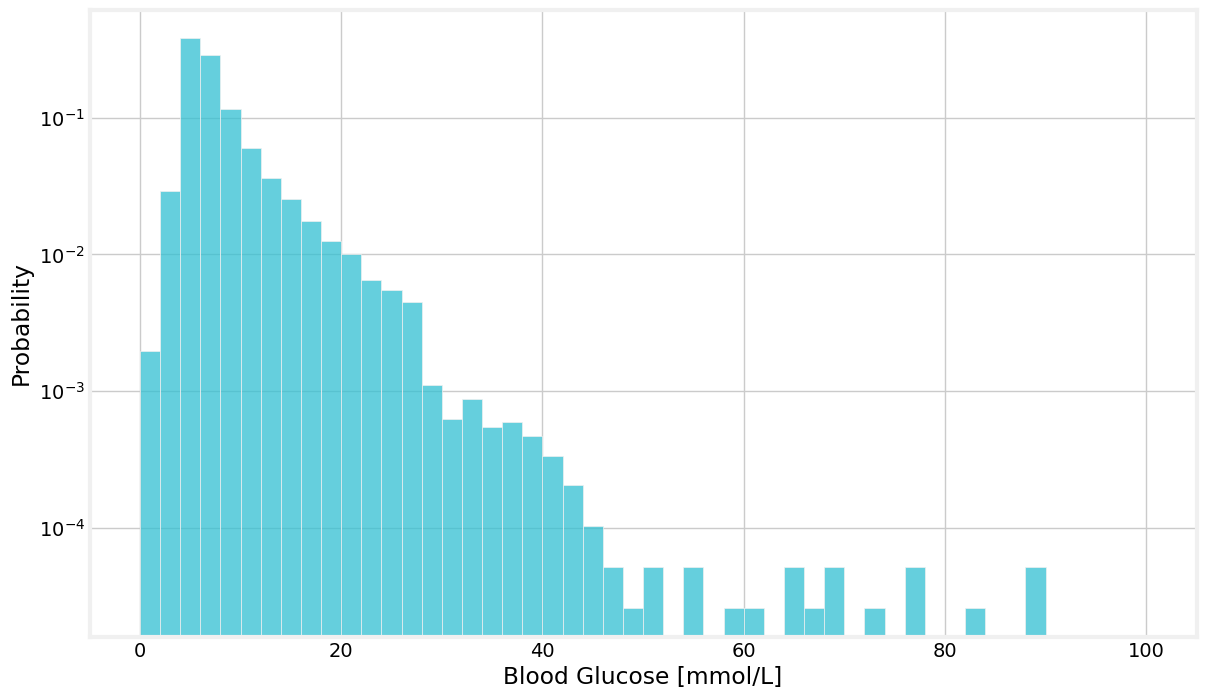

<Figure size 640x480 with 0 Axes>

In [84]:
from matplotlib.colors import to_rgba


warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)


plt.style.use('./CEIH.mplstyle')
color_dict = {0: to_rgba('#32C0D2', 1),
                1: to_rgba("#E0B165", 1),}

# key='FirstTotalHaemoglobinArterial'

# for key in plotSettings.keys():
fig, ax = plt.subplots(figsize=(12, 7))
fig.tight_layout() 
plotSettingValues = plotSettings[key]
# print(plotSettingValues)
# print(key)
sns.histplot(data=Emergency_IPInfo_Complete_Numeric.loc[~Emergency_IPInfo_Complete_Numeric[key].isna()], x=key,  stat= 'probability', bins=plotSettingValues[0], 
            label=plotSettingValues[4] ,palette=color_dict,binrange=(plotSettingValues[1], plotSettingValues[2]))
ax.set(xlabel=plotSettingValues[4])
plt.yscale(plotSettingValues[3])
plt.figure()


FirstAlbumin
Albumin Level


<Figure size 640x480 with 0 Axes>

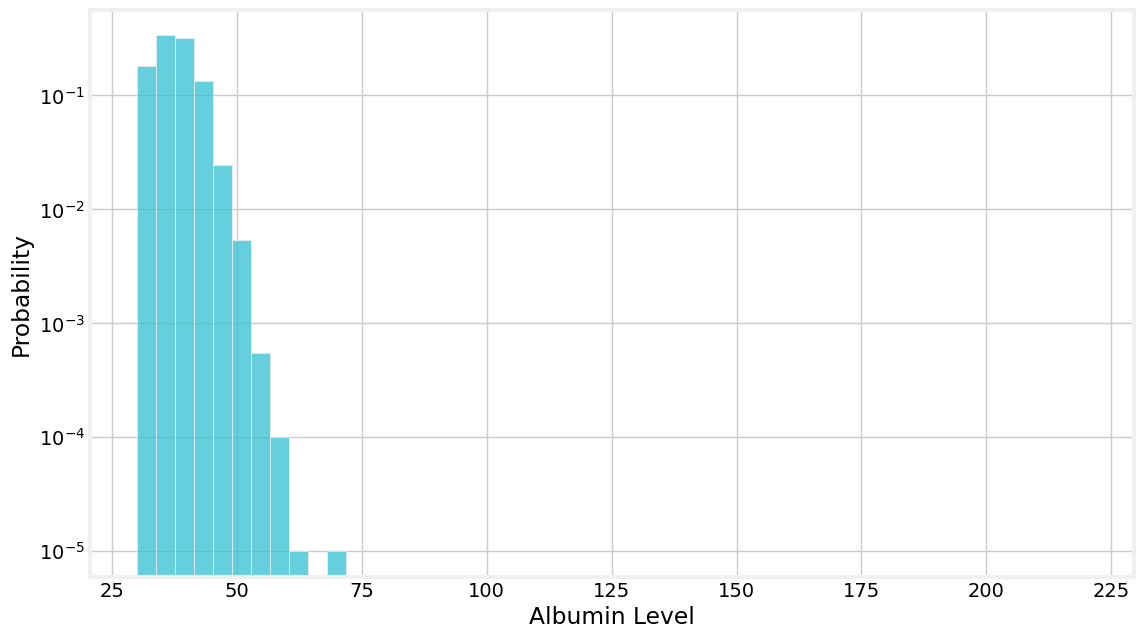

<Figure size 640x480 with 0 Axes>

In [85]:
key='FirstAlbumin'
f, ax = plt.subplots(figsize=(12, 7))
# plotSettingValues = plotSettings[key]
# print(plotSettingValues)
print(key)
print({**Obs_Of_Interest, **Res_Of_Interest}[key])
sns.histplot(data=Emergency_IPInfo_Complete_Numeric.loc[~Emergency_IPInfo_Complete_Numeric[key].isna()], x=key,  stat= 'probability', bins=50, label={**Obs_Of_Interest, **Res_Of_Interest}[key] , 
             palette=color_dict,binrange=(30,220),)
ax.set(xlabel={**Obs_Of_Interest, **Res_Of_Interest}[key])
plt.yscale('log')
# plt.yscale('linear')
plt.figure()

In [86]:
print(res2_df[res2_df.ITEMNAME=={**Obs_Of_Interest, **Res_Of_Interest}[key]].REFERENCELOWERLIMIT.unique())
print(res2_df[res2_df.ITEMNAME=={**Obs_Of_Interest, **Res_Of_Interest}[key]].REFERENCEUPPERLIMIT.unique())

['34' '31' '30' None '28' '26']
['48' '40' None '43']


In [87]:
key

'FirstAlbumin'

In [88]:
all_obs_df[all_obs_df.OBSERVATIONDESC=={**Obs_Of_Interest, **Res_Of_Interest}[key]]

,ObservationGUID,VISITIDCODE,CLIENTVISITGUID,CLIENTGUID,OBSITEMGUID,OBSERVATIONDESC,DATEENTERED,OBSERVATIONVALUE,SORTSEQNUM,UNITOFMEASURE


In [89]:
for key in plotSettings.keys():
    minLimit = res2_df[res2_df.ITEMNAME=={**Obs_Of_Interest, **Res_Of_Interest}[key]].REFERENCELOWERLIMIT.unique()
    maxLimit = res2_df[res2_df.ITEMNAME=={**Obs_Of_Interest, **Res_Of_Interest}[key]].REFERENCEUPPERLIMIT.unique()
    print(key,minLimit,maxLimit)

KeyError: 'AGEONADMISSION'

In [90]:
res2_df[(res2_df.ITEMNAME=={**Obs_Of_Interest, **Res_Of_Interest}[key])&(res2_df.REFERENCELOWERLIMIT=='30')]

KeyError: 'AGEONADMISSION'